In [1]:
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthl

In [2]:
import tensorflow as tf
import json
import numpy as np 
from matplotlib import pyplot as plt
import cv2

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Prepare Images and Labels

In [4]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['keypoints']]

def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('/kaggle/input/iris-tracking-dataset/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x / 255)

test_images = tf.data.Dataset.list_files('/kaggle/input/iris-tracking-dataset/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x / 255)

val_images = tf.data.Dataset.list_files('/kaggle/input/iris-tracking-dataset/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x / 255)

In [6]:
train_labels = tf.data.Dataset.list_files('/kaggle/input/iris-tracking-dataset/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files('/kaggle/input/iris-tracking-dataset/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files('/kaggle/input/iris-tracking-dataset/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [7]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6300, 6300, 1380, 1380, 1320, 1320)

In [8]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1200)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### View Images and Annotations

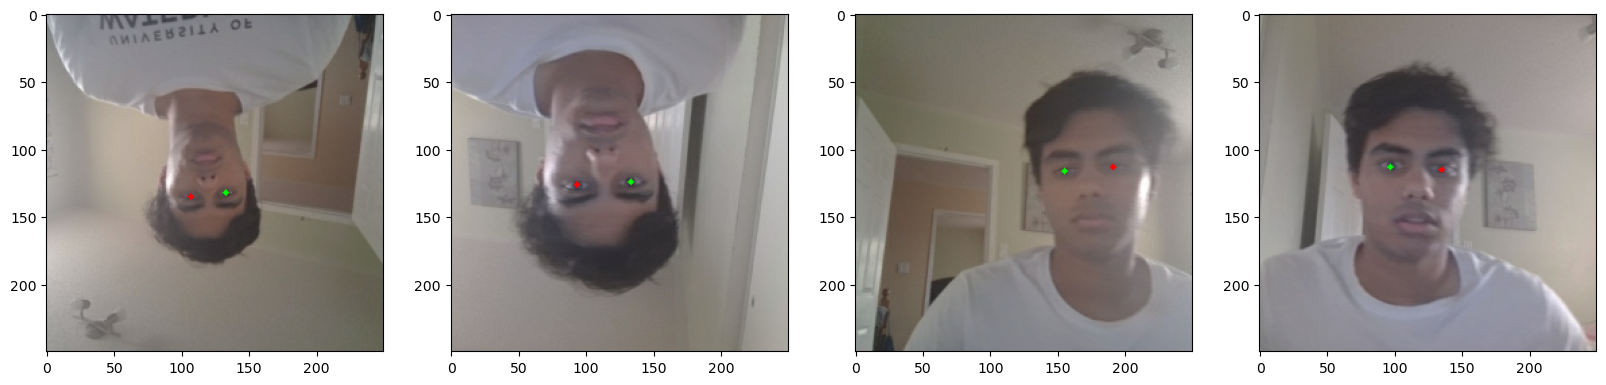

In [10]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### Build the Neural Network

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [10]:
def build_model():
    base_model = ResNet152V2(include_top=False, input_shape=(250, 250, 3))
    
    x = base_model.output
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(256, 2, strides=2, activation='relu')(x)
    x = Dropout(0.05)(x)
    x = Conv2D(4, 2, strides=2)(x)
    x = Reshape((4,))(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

In [11]:
model = build_model()
model.summary()

234561536/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [12]:
X, y = train.as_numpy_iterator().next()

In [13]:
X.shape

(8, 250, 250, 3)

### Training

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [16]:
model.compile(optimizer, loss)

In [17]:
hist = model.fit(train, epochs=60, validation_data=val)

Epoch 1/60
788/788 [==============================] - 201s 217ms/step - loss: 0.1789 - val_loss: 0.0178
Epoch 2/60
788/788 [==============================] - 173s 210ms/step - loss: 0.0062 - val_loss: 0.0095
Epoch 3/60
788/788 [==============================] - 173s 210ms/step - loss: 0.0042 - val_loss: 0.0145
Epoch 4/60
788/788 [==============================] - 173s 210ms/step - loss: 0.0034 - val_loss: 0.0143
Epoch 5/60
788/788 [==============================] - 172s 209ms/step - loss: 0.0033 - val_loss: 0.0068
Epoch 6/60
788/788 [==============================] - 172s 209ms/step - loss: 0.0018 - val_loss: 0.0079
Epoch 7/60
788/788 [==============================] - 173s 209ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 8/60
788/788 [==============================] - 172s 210ms/step - loss: 0.0012 - val_loss: 0.0069
Epoch 9/60
788/788 [==============================] - 173s 211ms/step - loss: 0.0042 - val_loss: 0.0385
Epoch 10/60
788/788 [==============================] - 173s 210m

In [18]:
hist.history

{'loss': [0.17888933420181274,
  0.006165313068777323,
  0.004167454317212105,
  0.0034285448491573334,
  0.003323025070130825,
  0.0018393987556919456,
  0.0013909970875829458,
  0.001248829998075962,
  0.00418788380920887,
  0.0050819627940654755,
  0.0022331883665174246,
  0.0019040857441723347,
  0.0030285276006907225,
  0.0019704720471054316,
  0.0009113340056501329,
  0.001706866198219359,
  0.0008043192210607231,
  0.0006512313266284764,
  0.0022803640458732843,
  0.001057019573636353,
  0.0005889157182537019,
  0.0009677362977527082,
  0.0008688631351105869,
  0.0004369966918602586,
  0.00045557861449196935,
  0.00034488533856347203,
  0.0007282178848981857,
  0.0006664276006631553,
  0.0003803898871410638,
  0.00028431194368749857,
  0.00020572799257934093,
  0.00018428148177918047,
  0.00021566011128015816,
  0.00025863005430437624,
  0.00020893097098451108,
  0.0001870702690212056,
  0.00017498328816145658,
  0.00016093210433609784,
  0.00014888757141306996,
  0.000167766091

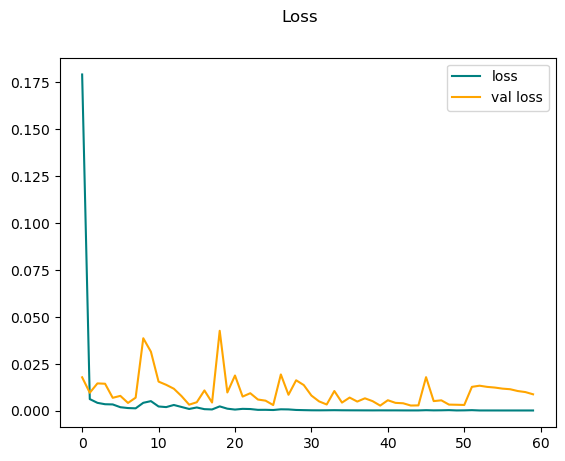

In [19]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [20]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [21]:
yhat = model.predict(test_sample[0])

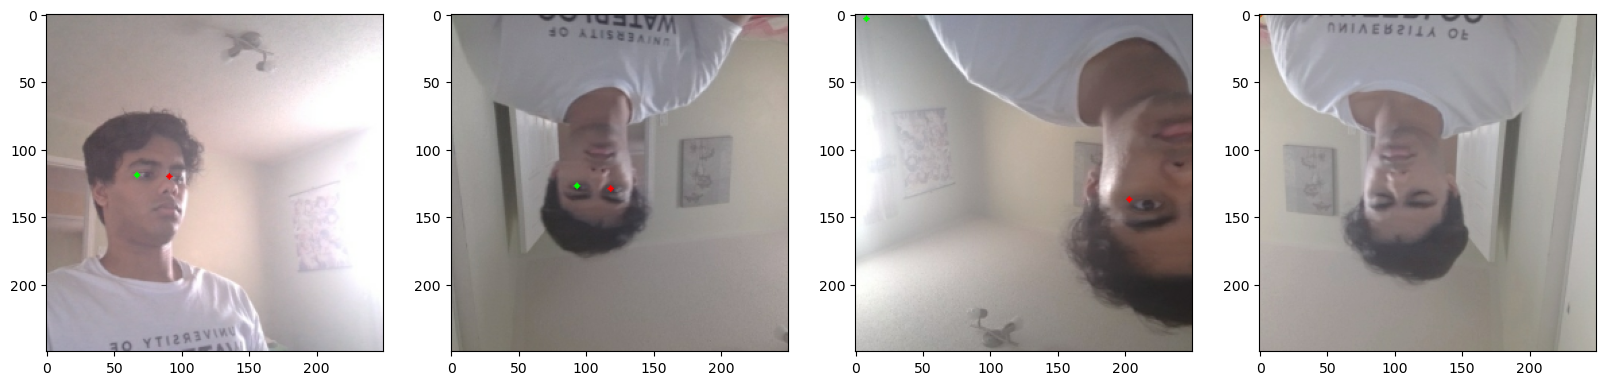

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [23]:
from tensorflow.keras.models import load_model

In [25]:
model.save('iris.h5')
model = load_model('iris.h5')